# Predicting risk factors for maternal mortality
by Apoorva Srivastava, Guaner (Gloria) Yi, Jeffrey Ding & Randall Lee 2025/11/22

In [1]:
import numpy as np
import pandas as pd
import requests
import zipfile
import json
import logging
import pandera.pandas as pa
from pandera import Check
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
from sklearn.metrics import fbeta_score, make_scorer, recall_score, ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay, roc_auc_score

# Summary

In this project, we built a Support Vector Classifier (SVC) that draws from maternal health measurements to predict the risk intensity levels (low, medium, or high) of pregnant women. Data was sourced from the “Maternal Health Risk” dataset from the UCI Machine Learning Repository and was originally collected by Marzia Ahmed and her team. Our final classifier performed fairly well on an unseen test data set, with a weighted recall score of 0.77 and an overall accuracy of 0.77. Out of the 305 test data cases, it correctly predicted 235 cases. The model showed particularly strong performance in identifying high-risk pregnancies, achieving an AUV of 0.943 for the high-risk class, compared to 0.820 for low-risk class and 0.814 for medium-risk class. However, the model made notable errors where 13 high-risk cases were misclassified as 11 medium-risk and 2 low-risk. These false negatives are gaps where high-risk individuals may not receive the necessary care.

We recommend further research to improve the model's sensitivity to high-risk cases and better differentiate between medium and low-risk categories before it is ready to be put into production in clinical settings. Additional feature engineering or exploring ensemble methods may help reduce these critical misclassifications. The implementation of refined classifiers would expand the capabilities of most healthcare systems and increase the efficacy of monitoring and interventions in underprivileged communities.

# Introduction

Maternal mortality is a serious issue that predates human history and still affects many mothers today. Among women of reproductive age, 9% of global deaths are currently attributable to maternal causes such as hemorrhaging, hypertension, and unsafe abortion (Hassfurter, 2025). Fortunately, gradual improvements in medical understanding, policy, healthcare, and overall quality of life have led to steadily decreasing maternal mortality rates. Recent UNICEF reports from 2023 place the global maternal mortality ratio at 197 per 100,000 live births, which is approximately 40% less than the reported ratio from 2000. Despite these trends, many rural and underserved communities continue to experience higher rates of maternal mortality.

Bangladesh is a country that has an overall maternal mortality ratio of 196 per 100,000 live births; however, deeper investigation reveals significant differences in mortality rate between women of different socioeconomic backgrounds (Hossain et. al, 2023). Mortality rate was higher among women with no education, women in rural areas, and women in poor wealth categories. According to a paper published in The Lancet, focusing research on the biomedical causes of mortality is insufficient, and more attention should be directed towards needs such as "primary prevention, early identification, and adequate management of pregnancy, labour, and postpartum complications" (Souza et. al, 2024).

A welcome innovation has been the development of wearable technology and internet-enabled devices that have allowed patients and physicians to reliably monitor health conditions from their homes (Kashem et. al, 2020). Additionally, these devices enabled the collection of physiological data from otherwise underserved communities. We aim to predict maternal health risk levels using clinical measurements gathered from pregnant individuals in rural Bangladesh. The ability to accurately predict high-risk pregnancies would allow timely and focused medical interventions for vulnerable individuals.

# Methods

## Data
The data set used in this project is of health conditions of pregnant women from the rural areas of Bangladesh created by Marzia Ahmed at Daffodil International University. This dataset was sourced from the UC Irvine Machine Learning Repository and can be found [here](https://archive.ics.uci.edu/dataset/863/maternal+health+risk). Each observation in the dataset corresponds to a pregnant individual's health profile, comprising a risk intensity level (low, medium, or high risk) and associated clinical measurements including demographic information (age) and vital signs (systolic blood pressure, diastolic blood pressure, blood glucose concentration, body temperature, and resting heart rate). The data set was collected via an IoT-based risk monitoring system from hospitals, community clinics, and maternal health cares in rural Bangladesh.

### Data dictionary
| Column Name | Role    | Type        | Description |
|-------------|---------|-------------|-------------|
| Age         | Feature | Integer     | Age of the patient during pregnancy (in years) |
| SystolicBP  | Feature | Integer     | Systolic (upper) blood pressure measured in mmHg |
| DiastolicBP | Feature | Integer     | Diastolic (lower) blood pressure measured in mmHg |
| BS          | Feature | Integer     | Blood sugar level measured in mmol/L |
| BodyTemp    | Feature | Integer     | Body temperature of the patient measured in °F |
| HeartRate   | Feature | Integer     | Patient's resting heart rate measured in bpm |
| RiskLevel   | Target  | Categorical | Predicted pregnancy risk level based on clinical features |

## Analysis
SVC was used to build a classification model to predict risk levels for pregnant women in rural Bangladesh. With the exception of diastolic blood pressure, all variables from the original dataset were included for analysis. The features used were age, systolic blood pressure, blood glucose level (BS), body temperature, and heart rate. Data was partitioned into a 70:30 train-test split and the random_state was set to 123 for reproducibility. We performed hyperparameter tuning using randomized search with 10-fold cross-validation and recall score (weighted) as our evaluation metric to select the optimal values for C (regularization parameter), gamma (kernel coefficient). Recall score was selected to optimize the model for sensitivity in predicting high-risk cases. All explanatory variables were numerical and were standardized via StandardScalar prior to fitting. The Python programming language and the following Python packages were used to perform the analysis: requests, zipfile, numpy, Pandas, altair, seaborn, and scikit-learn.

## Results & Discussion

### EDA
Preliminary exploratory data analysis (EDA) was performed to briefly examine each explanatory variable. Previous research have described hypertension as a complication risk; therefore, we dropped diastolic BP for the more commonly significant systolic.  Distributions of each explanatory variable were plotted using histograms and coloured according to risk levels (blue: high risk, green: medium risk, orange: low risk). The plotted distibutions were visually distinct across risk levels. Thus, we continued to fit our model with the remaining features.

In [2]:
# download data as zip and extract
url = "https://archive.ics.uci.edu/static/public/863/maternal+health+risk.zip"

request = requests.get(url)
with open("../data/raw/maternal+health+risk.zip", 'wb') as f:
    f.write(request.content)

with zipfile.ZipFile("../data/raw/maternal+health+risk.zip", 'r') as zip_ref:
    zip_ref.extractall("../data/raw")

In [3]:
health_data = pd.read_csv("../data/raw/Maternal Health Risk Data Set.csv", header=0)
health_data

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk


## Data Validation

### Validation Ranges

- For `Age`, we chose a validation range of 10-65 years. The lower limit of 10 accounts for rare cases of very early pregnancy, though pregnancies below the age of 15 are generally medically concerning. The upper limit of 65 represents the maximum biologically feasible range for pregnancy, though pregnancies beyond menopause are extremely rare and would usually require medical intervention. In very rare cases, values outside this range may occur but we can consider them extreme outliers, not suitable for our prediction task.
- For `SystolicBP`, we chose a validation range of 60-200 mmHg. Systolic blood pressure below 60 mmHg indicates severe hypotension, whereas systolic blood pressure above 200 mmHg indicates severe hypertension, both of which are life-threatening emergencies requiring immediate medical intervention. Since our model aims to classify routine maternal health risk levels, values outside the validation range are outside the scope of our classification model and would be considered outliers.
- For `DiastolicBP`, we chose a validation range of 40-140 mmHg. Diastolic blood pressure below 40 mmHg indicates severe hypotension, whereas diastolic blood pressure above 140 mmHg indicates severe hypertension, both of which are life-threatening emergencies requiring immediate medical intervention. Since our model aims to classify routine maternal health risk levels, values outside the validation range are outside the scope of our classification model and would be considered outliers.
- For `BS`, we chose a validation range of 1-25 mmol/L. Blood sugar below 1 mmol/L indicates severe hypoglycemia, whereas blood sugar above 25 mmol/L indicates severe hyperglycemia. Both of these are life-threatening emergencies requiring immediate hospitalization and can therefore be considered unsuitable for our predictive model.
- For `BodyTemp`, we chose a validation range of 95.0-105.0°F. Body temperature below 95.0°F indicates severe hypothermia, whereas body temperature above 105.0°F indicates severe hyperthermia. Both of these are life-threatening emergencies requiring immediate hospitalization and can therefore be considered as unsuitable for our predictive model.
- For `HeartRate`, we chose a validation range of 50-150 bpm. A resting heart rate below 50 bpm or above 150 bpm suggests potential cardiovascular problems requiring immediate medical intervention. Neither of the extreme values is compatible with normal maternal health assessment, and such values can be considered outliers.
- The target variable `RiskLevel` is a categorical variable representing the maternal health risk classification based on clinical assessment. Each observation must contain exactly one of these three risk levels: `low risk`, `mid risk` and `high risk`.

In [4]:
def validate_file_format(file_path, expected_file_extension):
    """
    Function to check if the file has the correct format,
    given the file path and expected file extension.
    """
    if not file_path.endswith(expected_file_extension):
        error_msg = "Invalid file format."
        raise ValueError(error_msg)

expected_file_extension = ".csv"
file_path = "data/raw/Maternal Health Risk Data Set.csv"

In [5]:
def validate_column_names(data, expected_columns):
    """
    Function to check if the DataFrame has the correct column names,
    given the DataFrame and the expected column names.
    """
    actual_columns = data.columns.tolist()
    
    missing_columns = set(expected_columns) - set(actual_columns)
    if missing_columns:
        error_msg = "Missing required columns."
        raise ValueError(error_msg)

    extra_columns = set(actual_columns) - set(expected_columns)
    if extra_columns:
        error_msg = "Unexpected extra columns found."
        raise ValueError(error_msg)

expected_columns = ["Age", "SystolicBP", "DiastolicBP", "BS", "BodyTemp", "HeartRate", "RiskLevel"]

In [6]:
# Code reference: https://github.com/skysheng7/DSCI522_data_validation_demo/blob/main/notebooks/00_python_data_validation_pandera.ipynb

# Configure logging
logging.basicConfig(
    filename="validation_errors.log",
    filemode="w",
    format="%(asctime)s - %(message)s",
    level=logging.INFO,
)

# Define the schema
schema = pa.DataFrameSchema(
    {
        "RiskLevel": pa.Column(str, pa.Check.isin(["low risk", "mid risk", "high risk"]), nullable=True),
        "Age": pa.Column(int, pa.Check.between(10, 65), nullable=True),
        "SystolicBP": pa.Column(int, pa.Check.between(60, 200), nullable=True),
        "DiastolicBP": pa.Column(int, pa.Check.between(40, 140), nullable=True),
        "BS": pa.Column(float, pa.Check.between(1.0, 25.0), nullable=True),
        "BodyTemp": pa.Column(float, pa.Check.between(95.0, 105.0), nullable=True),
        "HeartRate": pa.Column(int, pa.Check.between(50, 150), nullable=True)
    },
    checks=[
        pa.Check(lambda df: ~df.duplicated().any(), error="Duplicate rows found."),
        pa.Check(lambda df: ~(df.isna().all(axis=1)).any(), error="Empty rows found."),
        pa.Check(lambda df: (df.isna().mean() <= 0.05).all(), error="Some columns have more than 5% missing values."),
    ],
    drop_invalid_rows=False,
)

# Initialize error cases DataFrame
error_cases = pd.DataFrame()
data = health_data.copy()

# Validate data and handle errors: correct file format, correct column names
try:
    validate_file_format(file_path, expected_file_extension)
    validate_column_names(data, expected_columns)
except ValueError as e:
    # Convert the error message to a JSON string
    error_message = json.dumps(str(e), indent=2)
    logging.error("\n" + error_message)

# Validate data and handle errors: no empty observations, missingness not beyond threshold,
# correct data types for columns, no outliers, correct category levels
try:
    validated_data = schema.validate(data, lazy=True)
except pa.errors.SchemaErrors as e:
    error_cases = e.failure_cases

    # Convert the error message to a JSON string
    error_message = json.dumps(e.message, indent=2)
    logging.error("\n" + error_message)

# Filter out invalid rows based on the error cases: keep the duplicate rows (explanation below)
if not error_cases.empty:
    invalid_indices = error_cases["index"].dropna().unique()
    validated_data = (
        data.drop(index=invalid_indices)
        .reset_index(drop=True)
        .dropna(how="all")
    )
else:
    validated_data = data

In [7]:
print("Data shape before validation:")
print(data.shape)

print("Data shape after validation:")
print(validated_data.shape)

Data shape before validation:
(1014, 7)
Data shape after validation:
(1010, 7)


### Data Validation Results

We dropped 4 observations during our preliminary data validation, as these rows contain invalid data entires that would introduce noise into our model. More details about which observations have been dropped can be found under `validation_errors.log` in the `notebooks` folder. 

The validation log shows that the dropped observations include:
- 2 rows with `Age` outside the expected range (10-65 years): ages 66 and 70
- 2 rows with `HeartRate` of 7 bpm, which seems an impossibility for living people

#### Duplicate Observations

We have retained the 562 duplicate rows found in our data validation checks. Since the [original data set](https://archive.ics.uci.edu/dataset/863/maternal+health+risk) lacks unique patient identifiers (no patient ID or timestamp), we cannot definitely determine whether these duplicates represent the same patient measured multiple times or different patients with identical measurements. Given this uncertainty and the substantial dataset reduction that would result from removing the duplicates, we opted to keep all duplicate rows and only remove observations that clearly fail other data validation checks. 

The dataset passed all other validation checks, namely:
- Correct data file format
- Correct column names
- No empty observations
- Missingness not beyond expected threshold: all columns have <5% missing values (threshold = 0.05)
- Correct data types in each column
- Correct category levels: all categorical values match expected levels
- No outliers: all numeric values fall within reasonable ranges (with the exception of the 4 dropped rows)

Our final validated dataset `validated_data` contains 1,010 observations. 

In [4]:
health_data.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


In [5]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [6]:
train_df, test_df = train_test_split(
    health_data, test_size=0.3, random_state=123
)
X_train, y_train = train_df.drop(columns=['RiskLevel']), train_df["RiskLevel"]
X_test, y_test = test_df.drop(columns=['RiskLevel']), test_df["RiskLevel"]

train_df.to_csv("../data/processed/maternal_health_risk_train.csv")
test_df.to_csv("../data/processed/maternal_health_risk_test.csv")

In [7]:
train_df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
1003,50,130,100,16.0,98.0,76,high risk
243,32,120,65,6.0,101.0,76,mid risk
848,15,70,50,6.0,98.0,70,mid risk
202,23,90,60,7.5,98.0,76,low risk
300,15,75,49,7.7,98.0,77,low risk
...,...,...,...,...,...,...,...
988,25,120,90,12.0,101.0,80,high risk
322,65,90,60,6.9,98.0,70,low risk
382,17,90,65,7.8,103.0,67,high risk
365,22,120,90,7.8,98.0,82,mid risk


In [8]:
test_df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
50,25,120,80,7.0,98.0,66,low risk
784,35,100,70,6.8,98.0,60,mid risk
204,15,76,49,7.5,98.0,77,low risk
85,18,90,60,6.9,98.0,70,mid risk
802,42,130,80,18.0,98.0,70,mid risk
...,...,...,...,...,...,...,...
619,29,130,70,7.5,98.0,78,mid risk
607,45,120,95,7.5,98.0,66,low risk
700,15,120,80,6.6,99.0,70,low risk
1005,17,90,65,7.7,103.0,67,high risk


In [9]:
y_train.value_counts()

RiskLevel
low risk     286
mid risk     238
high risk    185
Name: count, dtype: int64

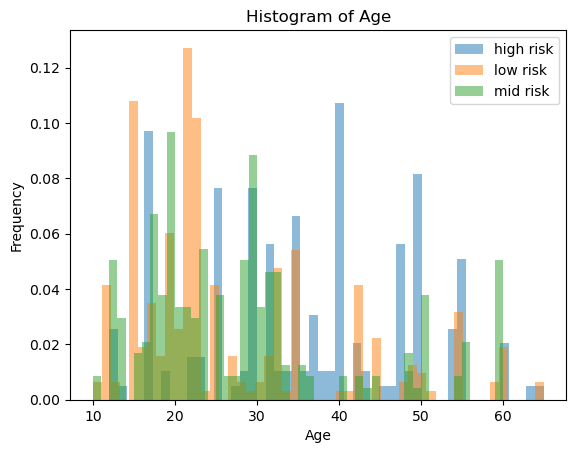

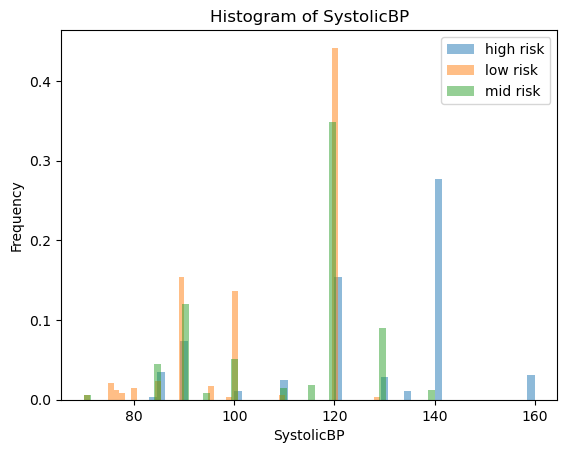

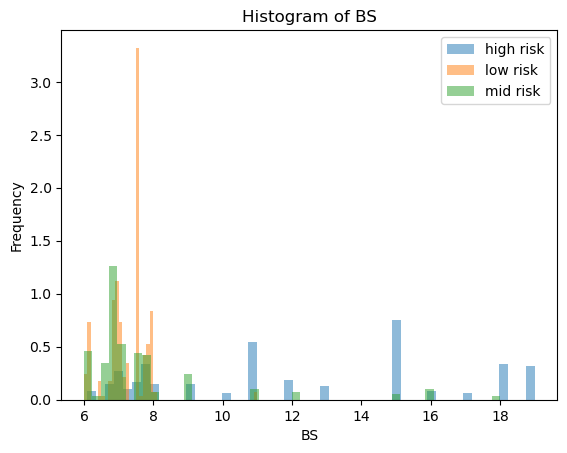

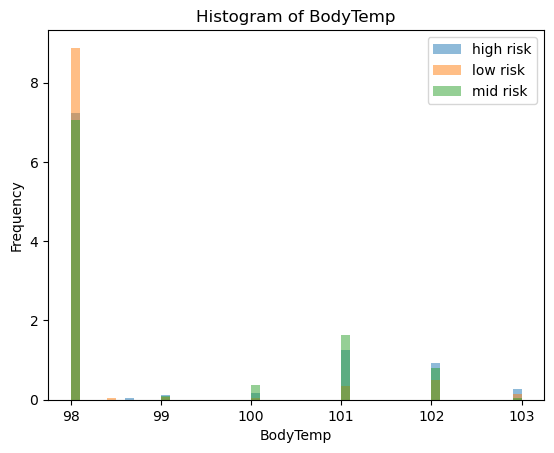

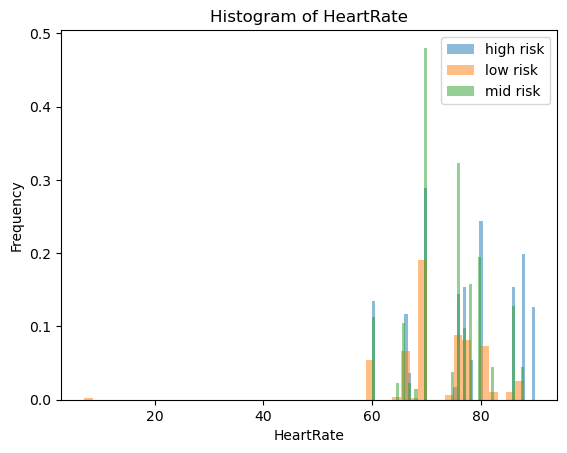

In [10]:
feature_cols = ["Age", "SystolicBP", "BS", "BodyTemp", "HeartRate"]

for feature in feature_cols:
    train_df.groupby("RiskLevel")[feature].plot.hist(bins=50, alpha=0.5, legend=True, density = True, title = "Histogram of " + feature);
    plt.xlabel(feature);
    plt.show()

Figure 1. Comparison of the distributions of features contributing to the risk intensity level during pregnancy of an individual.

### Model construction

We selected a Support Vector Classifier (SVC) model for this classification task. To identify the model configuration that best predicted maternal health risk levels, we performed hyperparameter tuning using randomized search with 10-fold cross-validation and recall score (weighted) as our evaluation metric to select the optimal values for C (regularization parameter), gamma (kernel coefficient). We found that the optimal hyperparameters were 760 for C and 5.8 for gamma.

In [11]:
preprocessor = make_column_transformer(
    (StandardScaler(), feature_cols)
)

In [12]:
preprocessor.fit(X_train)

,transformers,"[('standardscaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [34]:
X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train), 
    index=X_train.index, 
    columns=preprocessor.get_feature_names_out()
)  

# Show the transformed data
X_train_enc

,standardscaler__Age,standardscaler__SystolicBP,standardscaler__BS,standardscaler__BodyTemp,standardscaler__HeartRate
1003,1.539667,0.915275,2.278454,-0.499908,0.209123
243,0.182676,0.373190,-0.820502,1.630962,0.209123
848,-1.098927,-2.337235,-0.820502,-0.499908,-0.543507
202,-0.495820,-1.253065,-0.355659,-0.499908,0.209123
300,-1.098927,-2.066193,-0.293680,-0.499908,0.334561
...,...,...,...,...,...
988,-0.345043,0.373190,1.038872,1.630962,0.710876
322,2.670493,-1.253065,-0.541596,-0.499908,-0.543507
382,-0.948150,-1.253065,-0.262690,3.051541,-0.919822
365,-0.571208,0.373190,-0.262690,-0.499908,0.961753


In [14]:
dc = DummyClassifier()

In [15]:
dc_score = pd.DataFrame(cross_validate(dc, X_train, y_train, cv=5, return_train_score=True))

In [16]:
dc_score

,fit_time,score_time,test_score,train_score
0,0.000641,0.000447,0.401408,0.403880
1,0.000337,0.000245,0.401408,0.403880
2,0.000273,0.000233,0.401408,0.403880
3,0.000254,0.000222,0.408451,0.402116
4,0.000251,0.000216,0.404255,0.403169


In [17]:
svc = make_pipeline(preprocessor, SVC())

In [18]:
svc_score = pd.DataFrame(cross_validate(svc, X_train, y_train, cv=5, return_train_score=True))

In [19]:
svc_score

,fit_time,score_time,test_score,train_score
0,0.006806,0.003258,0.725352,0.707231
1,0.006260,0.003011,0.676056,0.719577
2,0.006080,0.002871,0.718310,0.719577
3,0.005816,0.002983,0.711268,0.708995
4,0.005465,0.002876,0.659574,0.727113


### Hyperparameter tuning

Because we are attempting to classify clincal risk levels, we selected recall score as the preferred evaluation metric. This is because recall score measures the percentage correctly identified of actual high-risk pregnancies. This is critical for maternal health prediction where false negatives could result in missing high-risk, vulnerable individuals. Although prioritizing recall could increase the rate of false positive errors, it is the safer choice in this context.

In [20]:
svc_score = pd.DataFrame(cross_validate(svc, X_train, y_train, cv=5, return_train_score=True, scoring="recall_weighted"))

In [21]:
svc_score

,fit_time,score_time,test_score,train_score
0,0.007818,0.004066,0.725352,0.707231
1,0.005989,0.003474,0.676056,0.719577
2,0.006076,0.003580,0.718310,0.719577
3,0.005652,0.003213,0.711268,0.708995
4,0.005634,0.003230,0.659574,0.727113


In [22]:
param_grid = {
    "svc__C": loguniform(1e-2, 1e3),
    "svc__gamma": loguniform(1e-4, 1e1)
}

In [23]:
random_search = RandomizedSearchCV(svc,                                    
                  param_distributions=param_grid, 
                  n_iter=100, 
                  n_jobs=-1,
                  return_train_score=True,
                  cv=10,
                  scoring='recall_weighted',
                  random_state=123)

random_search.fit(X_train, y_train)

,estimator,"Pipeline(step...svc', SVC())])"
,param_distributions,"{'svc__C': <scipy.stats....t 0x33be33200>, 'svc__gamma': <scipy.stats....t 0x33ba233b0>}"
,n_iter,100
,scoring,'recall_weighted'
,n_jobs,-1
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,123
,error_score,nan


In [24]:
random_search.best_score_

np.float64(0.7629979879275655)

In [25]:
result_grid = pd.DataFrame(random_search.cv_results_)
result_grid = result_grid[
    [
        "mean_test_score",
        "param_svc__gamma",
        "param_svc__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T.iloc[:, :10]

result_grid

rank_test_score,1,2,3,4,5,6,7,8,9,10
mean_test_score,0.762998,0.760221,0.755956,0.753159,0.751771,0.734849,0.733400,0.730624,0.729215,0.720644
param_svc__gamma,1.615660,8.282366,1.280916,2.749691,9.479652,1.571147,8.468353,2.134628,1.766684,0.265551
param_svc__C,422.340226,323.263643,198.127782,21.103877,33.480671,34.953203,2.601185,10.080750,14.859520,801.347695
mean_fit_time,0.015070,0.014597,0.014507,0.011416,0.010271,0.010566,0.011817,0.009013,0.008407,0.028824


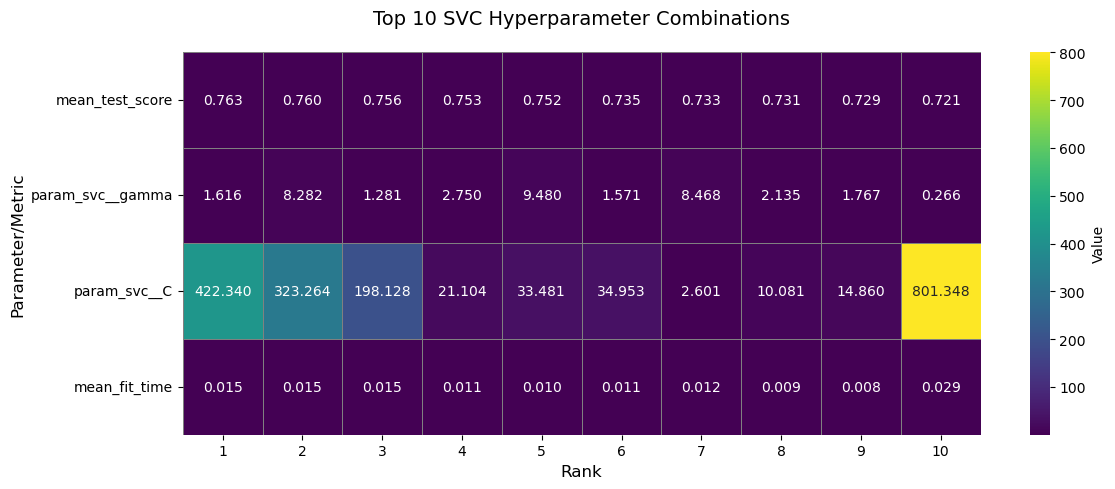

In [26]:
plt.figure(figsize=(12, 5))
sns.heatmap(result_grid, 
            annot=True,           
            fmt='.3f',           
            cmap='viridis',        
            cbar_kws={'label': 'Value'},
            linewidths=0.5,
            linecolor='gray')

plt.title('Top 10 SVC Hyperparameter Combinations', fontsize=14, pad=20)
plt.xlabel('Rank', fontsize=12)
plt.ylabel('Parameter/Metric', fontsize=12)
plt.tight_layout()
plt.show()

Figure 2. Results from hyperparameter optimization and 10-fold cross validation to choose gamma and C. Recall score was used as the classification metric as gamma and C was varied.

In [27]:
accuracy_score = random_search.score(
    X_test, y_test
)

In [28]:
accuracy_score

0.7836065573770492

In [29]:
maternal_preds = X_test.assign(
    predicted=random_search.best_estimator_.predict(X_test)
)

# Add the actual labels
maternal_preds['actual'] = y_test.values

# Compute recall score (weighted for multi-class)
recall = recall_score(
    maternal_preds['actual'],
    maternal_preds['predicted'],
    average='weighted'
)

In [30]:
recall

0.7836065573770492

In [31]:
pd.crosstab(
    maternal_preds["actual"],
    maternal_preds["predicted"],
)

predicted,high risk,low risk,mid risk
actual,,,
high risk,74,2,11
low risk,4,95,21
mid risk,9,19,70


Text(0.5, 1.0, 'Confusion Matrix - Test Data')

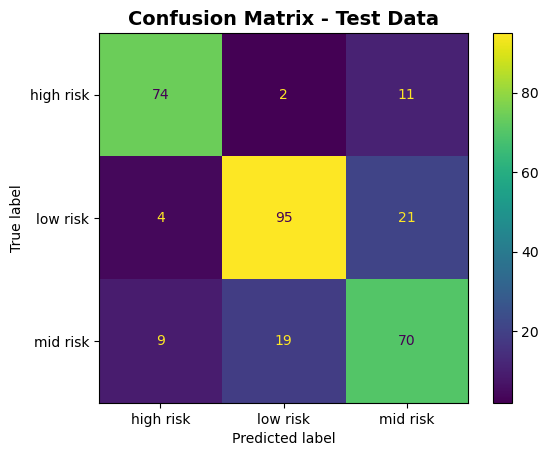

In [32]:
confmat_logreg_bal = ConfusionMatrixDisplay.from_predictions(
    y_test,
    random_search.best_estimator_.predict(X_test),
    #normalize='all'
)
confmat_logreg_bal.ax_.set_title('Confusion Matrix - Test Data', fontsize=14, fontweight='bold')

Figure 3. Confusion matrix of model performance on test data.

high risk: AUC = 0.952
low risk: AUC = 0.885
mid risk: AUC = 0.854


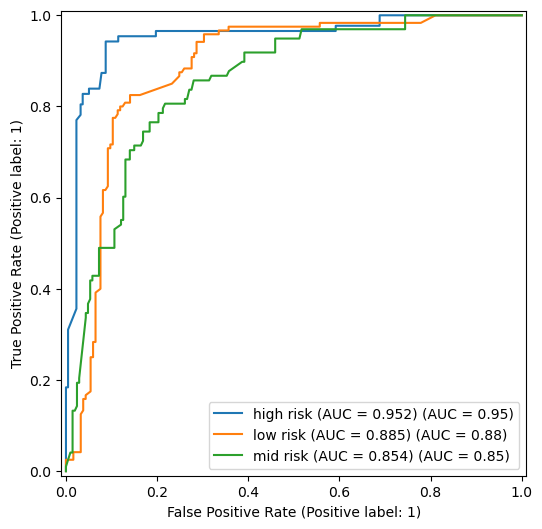

In [33]:
y_score = random_search.best_estimator_.decision_function(X_test)
svc_classes = random_search.best_estimator_.named_steps['svc'].classes_
y_test_bin = label_binarize(y_test, classes=svc_classes)
fig, ax = plt.subplots(figsize=(6, 8))

for i, class_name in enumerate(svc_classes):
    auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_score[:, i],
        name=f'{class_name} (AUC = {auc:.3f})',
        ax=ax
    )
    print(f"{class_name}: AUC = {auc:.3f}")

Figure 4. ROC curve of model performance on test data.

### Summary of Model Results

The final SVC classifier performed fairly well on an unseen test data set, with a weighted recall score of 0.77 and an overall accuracy of 0.77. Out of the 305 test data cases, it correctly predicted 235 cases. The model showed particularly strong performance in identifying high-risk pregnancies, achieving an AUV of 0.943 for the high-risk class, compared to 0.820 for low-risk class and 0.814 for medium-risk class. It correctly identifies 74 out of 87 actual high-risk pregnancies resulting in a 85% recall for high risk. The 13 notable errors were true high-risk cases were misclassified as 11 medium-risk and 2 low-risk. These false negatives are gaps where high-risk individuals may not receive the necessary care. We recommend further research to improve the model's sensitivity to high-risk cases and better differentiate between medium and low-risk categories before it is ready to be put into production in clinical settings.

## References

A.B.M. Sharif Hossain, Siddique, A., Jabeen, S., Khan, S., M Moinuddin Haider, Ameen, S., Tazeen Tahsina, Chakraborty, N., Nahar, Q., Jamil, K., Shams El Arifeen, & Ahmed Ehsanur Rahman. (2023). Maternal mortality in Bangladesh: Who, when, why, and where? A national survey-based analysis. Journal of Global Health, 13. https://doi.org/10.7189/jogh.13.07002

Ahmed, M., Kashem, M. A., Rahman, M., & Khatun, S. (2020). Review and Analysis of Risk Factor of Maternal Health in Remote Area Using the Internet of Things (IoT). Lecture Notes in Electrical Engineering, 357–365. https://doi.org/10.1007/978-981-15-2317-5_30

Hassfurter, K. (2025, April 6). Trends in maternal mortality 2000 to 2023 - UNICEF DATA. UNICEF DATA. https://data.unicef.org/resources/trends-in-maternal-mortality-2000-to-2023/

Souza, J. P., Day, L., Rezende-Gomes, A. C., Zhang, J., Mori, R., Baguiya, A., Jayaratne, K., Osoti, A., Vogel, J. P., Campbell, R., Mugerwa, K., Lumbiganon, P., Tunçalp, Ӧ., Cresswell, J. A., Say, L., Moran, A. C., & Oladapo, O. T. (2023). A Global Analysis of the Determinants of Maternal Health and Transitions in Maternal Mortality. The Lancet Global Health, 12(2). https://doi.org/10.1016/s2214-109x(23)00468-0